### Задание
Вы – продуктовый аналитик в классифайде. В компанию пришел новый дизайнер и предложил освежить дизайн и добавить анимацию при сохранении объявления в избранное. Ваша задача, проследить за целевой метрикой (конверсией из просмотра объявления в сохранение объявления в избранное). Основной риск – метрика может сократиться. Изменения планируются ввести сначала в одной платформе (IOS), а затем на других, если подтвердится гипотеза о том, что конверсия не упадет. Поэтому мы можем попробовать применить здесь causal inference без рандомизированных тестов. Новый дизайн блока “Избранные объявления” зарелизили на ios 1 июля 2022 года. 

Будем работать с данными классифайда, которые доступны в Clickhouse – таблицей `user_dm_events`.

Нас интересует три типа событий из этой таблицы:

- `cnt_add_to_favorites` - сохранение в избранное
- `cnt_view_advertisement` - просмотры объявления
- `cnt_display_phone` - кол-во показов телефона продавца покупателю (на карточке продавца)

Выгрузите сумму для каждого из этих событий, агрегированную по дням и платформам, за период 01.02.2022 - 15.07.2022. 

Посчитайте метрику отношения суммы событий сохранения в избранное к сумме просмотров объявления, агрегированную по дням и платформам, за тот же период. Назовите эту метрику `cr`.

Метрики `cr` и `cnt_display_phone` могут быть хорошими ковариатами, посмотрим, так ли это на самом деле.

Итоговый датасет должен иметь схему:

- `event_date` - дата агрегации
- `platform` - платформа совершения события
- `cnt_fav` - кол-во событий добавления в избранное
- `cnt_view` - кол-во просмотра объявлений
- `cnt_display_phone` - кол-во просмотра номера телефона 
- `cr` - отношение

In [1]:
import numpy as np
import pandas as pd
from clickhouse_driver import Client
from config import user_id, password
from matplotlib import pyplot as plt
import seaborn as sns
from causalimpact import CausalImpact
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from itertools import combinations
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

client = Client(
    host='clickhouse.lab.karpov.courses',
    port=9000,
    user=user_id,
    password=password,
    database='hardda'
)

def get_data(query):
    """
    Вытягивает данные из clickhouse в виде Dataframe
    
    query - запрос
    """
    result, columns = client.execute(query, with_column_types=True)
    return pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

### Задание 1 (1/2)

Агрегируйте датасет по дням, где одна строка датасета - один день, а по столбцам - метрики. На каждую комбинацию (платформа-метрика) отдельный столбец. Постройте график динамики метрики cr в разрезе платформ.

Укажите среднюю по целевой метрике отношения в платформе IOS `cr_ios` по дням до нововведения меньше `'2022-07-01'`

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [2]:
user_transactions_query = """
    SELECT event_date,
        platform,
        SUM(cnt_add_to_favorites) AS cnt_fav,
        SUM(cnt_view_advertisement) AS cnt_view,
        SUM(cnt_display_phone) AS cnt_display_phone,
        SUM(cnt_add_to_favorites) / SUM(cnt_view_advertisement) AS cr
    FROM user_dm_events
    WHERE event_date BETWEEN '2022-02-01' AND '2022-07-15'
    GROUP BY event_date, platform
    """

ut_df = get_data(user_transactions_query)
ut_df

,event_date,platform,cnt_fav,cnt_view,cnt_display_phone,cr
0,2022-06-02,android,42920,1475717,34164,0.029084
1,2022-06-28,ios,19621,516822,12483,0.037965
2,2022-04-18,ios,22804,633205,14099,0.036014
3,2022-02-19,ios,17286,507738,11343,0.034045
4,2022-03-30,android,50196,1775406,43112,0.028273
...,...,...,...,...,...,...
325,2022-03-27,android,55435,1992935,44901,0.027816
326,2022-04-23,ios,20434,582899,12763,0.035056
327,2022-06-23,ios,18700,488290,12370,0.038297
328,2022-02-16,ios,18000,538275,12695,0.033440


In [3]:
ut_df['event_date'] = pd.to_datetime(ut_df['event_date'])

In [4]:
exp_date = pd.to_datetime('2022-07-01')

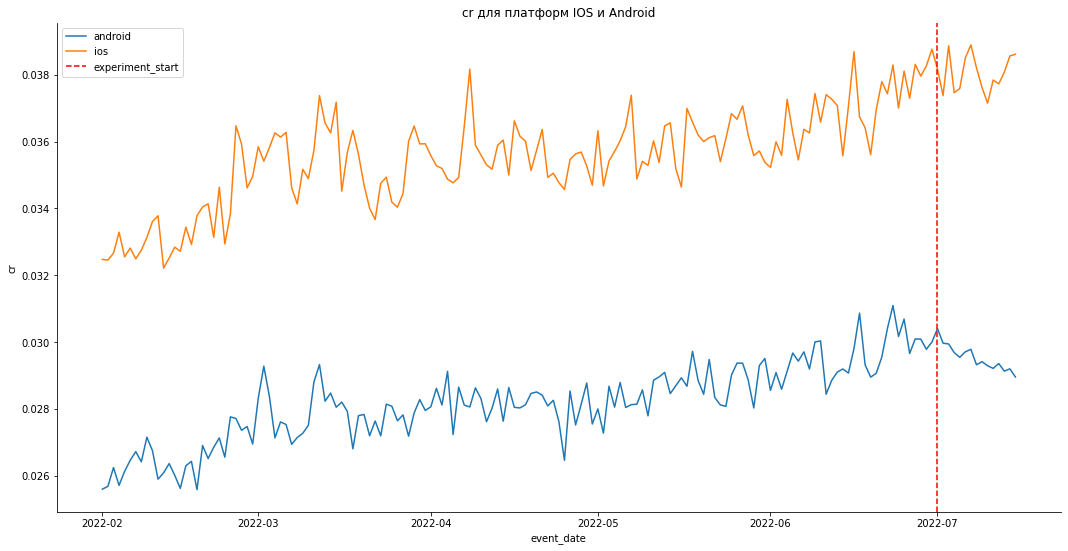

In [5]:
plt.figure(figsize=(18, 9))

sns.lineplot(data=ut_df, x='event_date', y='cr', hue='platform')
plt.axvline(exp_date, color='red', linestyle='dashed', label='experiment_start')
plt.legend()
plt.title('cr для платформ IOS и Android')
sns.despine()

In [6]:
round(ut_df[(ut_df['platform'] == 'ios') & (ut_df['event_date'] < exp_date)]['cr'].mean(), 3)

0.036

### Задание 1 (2/2)

Укажите среднюю по целевой метрике отношения в платформе IOS `cr_ios` по дням после нововведения `>= '2022-07-01'`

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [7]:
round(ut_df[(ut_df['platform'] == 'ios') & (ut_df['event_date'] >= exp_date)]['cr'].mean(), 3)

0.038

### Задание 2

Постройте корреляционную матрицу. Её нужно строить по pre данным. 

Найдите три наиболее скоррелированные с целевой метрикой `сr_ios` (именно в IOS у нас было воздействие) ковариаты.

In [8]:
platforms = list(ut_df['platform'].unique())
metrics = list(set(ut_df.columns) - set(platforms + ['event_date', 'platform']))

ut_df_pivot = ut_df.pivot(index='event_date', values=metrics, columns='platform')

new_columns = []
for metric in metrics:
    for platform in platforms:
        new_columns.append(f'{metric}_{platform}')

ut_df_pivot.columns = new_columns
ut_df_pivot.reset_index(inplace=True)

In [9]:
ut_df_pivot.head()

,event_date,cnt_view_android,cnt_view_ios,cr_android,cr_ios,cnt_display_phone_android,cnt_display_phone_ios,cnt_fav_android,cnt_fav_ios
0,2022-02-01,1946760.0,560769.0,0.025592,0.032473,41451.0,12221.0,49821.0,18210.0
1,2022-02-02,1936104.0,558109.0,0.025676,0.032454,41069.0,12456.0,49712.0,18113.0
2,2022-02-03,1890293.0,551167.0,0.026238,0.032660,41462.0,11644.0,49597.0,18001.0
3,2022-02-04,1810075.0,510172.0,0.025705,0.033289,40558.0,11052.0,46528.0,16983.0
4,2022-02-05,1792061.0,512377.0,0.026124,0.032550,39227.0,11102.0,46816.0,16678.0


In [10]:
pre_intervention_pivot = ut_df_pivot[ut_df_pivot['event_date'] < exp_date]
cols = list(set(ut_df_pivot.columns) - set(['event_date']))

pre_intervention_pivot[cols].corr().style.background_gradient(cmap='coolwarm', axis=None)

,cnt_view_ios,cnt_display_phone_ios,cnt_fav_android,cnt_fav_ios,cr_ios,cnt_display_phone_android,cr_android,cnt_view_android
cnt_view_ios,1.000000,0.794786,0.876254,0.903452,-0.331868,0.746078,-0.368949,0.822030
cnt_display_phone_ios,0.794786,1.000000,0.779614,0.832568,-0.016359,0.800585,-0.123136,0.660397
cnt_fav_android,0.876254,0.779614,1.000000,0.719666,-0.454857,0.927072,-0.463981,0.954738
cnt_fav_ios,0.903452,0.832568,0.719666,1.000000,0.103473,0.609166,-0.029146,0.580466
cr_ios,-0.331868,-0.016359,-0.454857,0.103473,1.000000,-0.400352,0.800127,-0.635744
cnt_display_phone_android,0.746078,0.800585,0.927072,0.609166,-0.400352,1.000000,-0.519268,0.913476
cr_android,-0.368949,-0.123136,-0.463981,-0.029146,0.800127,-0.519268,1.000000,-0.704531
cnt_view_android,0.822030,0.660397,0.954738,0.580466,-0.635744,0.913476,-0.704531,1.000000


### Задание 3 (1/2)

Проведите разовый Causal Impact анализ на метрику `cr_ios` и тремя лучшими метриками ковариатами, где днем `intervention` является `2022-07-01`. Отвергается ли нулевая гипотеза?

In [11]:
ci_df = ut_df_pivot[['event_date', 'cr_ios', 'cr_android', 'cnt_view_android', 'cnt_fav_android']]
ci_df.set_index('event_date', inplace=True)
ci_df.rename_axis(None, inplace=True)
ci_df.head()

,cr_ios,cr_android,cnt_view_android,cnt_fav_android
2022-02-01,0.032473,0.025592,1946760.0,49821.0
2022-02-02,0.032454,0.025676,1936104.0,49712.0
2022-02-03,0.032660,0.026238,1890293.0,49597.0
2022-02-04,0.033289,0.025705,1810075.0,46528.0
2022-02-05,0.032550,0.026124,1792061.0,46816.0


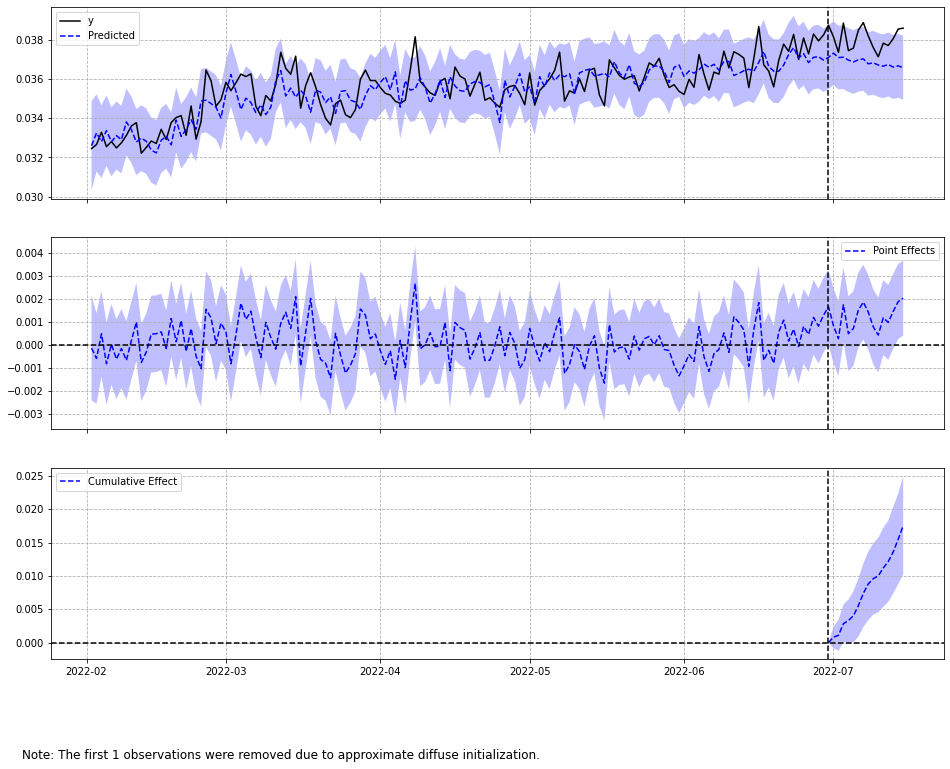

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.04               0.57
Prediction (s.d.)         0.04 (0.0)         0.55 (0.0)
95% CI                    [0.04, 0.04]       [0.55, 0.56]

Absolute effect (s.d.)    0.0 (0.0)          0.02 (0.0)
95% CI                    [0.0, 0.0]         [0.01, 0.02]

Relative effect (s.d.)    3.17% (0.68%)      3.17% (0.68%)
95% CI                    [1.85%, 4.51%]     [1.85%, 4.51%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [12]:
ts_pre_period = [pd.to_datetime(date) for date in ['2022-02-01', '2022-06-30']]
ts_post_period = [pd.to_datetime(date) for date in ['2022-07-01', '2022-07-15']]

ci = CausalImpact(ci_df, ts_pre_period, ts_post_period, alpha=0.05)
ci.plot(figsize = (16, 12))
print(ci.summary())

In [13]:
if ci.p_value < 0.05:
    print('H0 отвергается')
else:
    print('H0 не отвергается')

H0 отвергается


### Задание 3 (2/2)

Какой относительный размер эффекта находит модель?

Введите значение в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [14]:
print('Относительный размер эффекта CI модели =', round(ci.summary_data.loc['rel_effect', :][0], 3))

Относительный размер эффекта CI модели = 0.032


### Задание 4  

Какие элементы регрессионного уравнения имеют p-value < 0.05?

Проведите анализ коэффициентов модели.

In [15]:
ci.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                 cr_ios   No. Observations:                  150
Model:                    local level   Log Likelihood                -131.619
Date:                Wed, 27 Aug 2025   AIC                            273.239
Time:                        14:29:22   BIC                            288.258
Sample:                    02-01-2022   HQIC                           279.341
                         - 06-30-2022                                         
Covariance Type:                  opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
sigma2.irregular          0.3265      0.043      7.519      0.000       0.241       0.412
sigma2.level              0.0001      0.000      0.376      0.707      -0.001       0.001
beta.cr_android          -0.5684      0.484     -1.173      0.241      -1.518       0.381
beta.cnt_view_android    -3.9016      1.441     -2.707      0.007      -6.726      -1.077
beta.cnt_fav_android      3.0116      1.168      2.579      0.010       0.723       5.300
===================================================================================
Ljung-Box (L1) (Q):                   4.51   Jarque-Bera (JB):                 2.78
Prob(Q):                              0.03   Prob(JB):                         0.25
Heteroskedasticity (H):               0.84   Skew:                             0.31
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Задание 5 (1/3)

Проведите анализ остатков модели. Укажите верные утверждения по трем гипотезам относительно остатков. 

1. Остатки стационарны?

p-value Dickey-Fuller test = 0.000000
p-value t-test = 0.121894
p-value Ljung-Box test = 0.033779


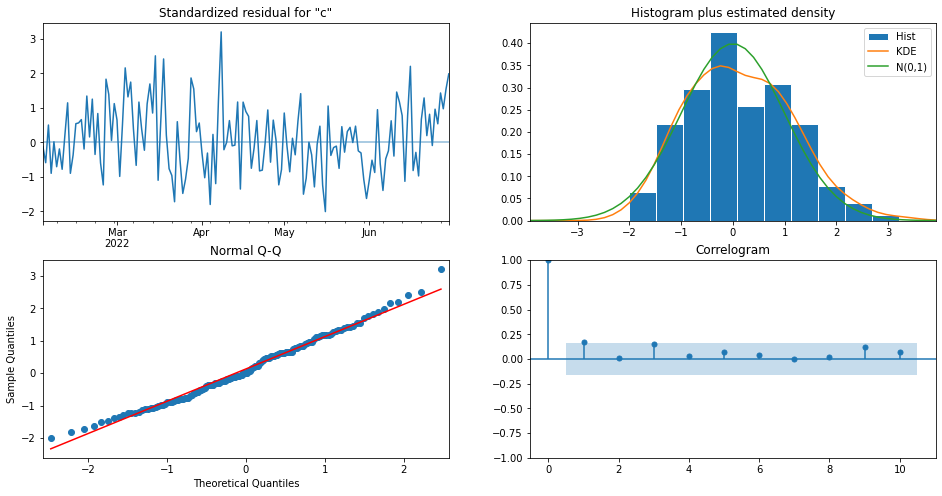

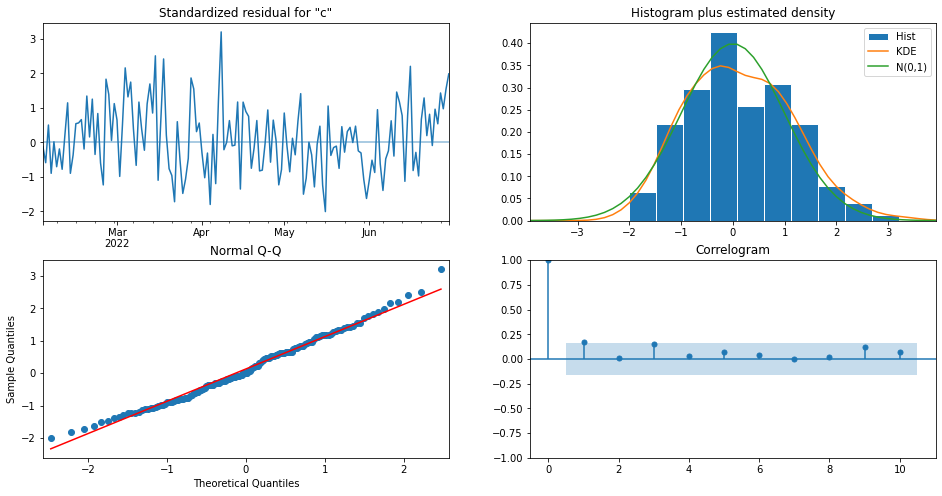

In [16]:
print("p-value Dickey-Fuller test = %f" % sm.tsa.stattools.adfuller(ci.trained_model.resid)[1])
print("p-value t-test = %f" % ttest_1samp(ci.trained_model.resid, 0)[1])
print("p-value Ljung-Box test = %f" % ci.trained_model.test_serial_correlation('ljungbox')[0, :, 0][1])
ci.trained_model.plot_diagnostics(figsize = (16, 8))

In [17]:
p_val_df = sm.tsa.stattools.adfuller(ci.trained_model.resid)[1]

if p_val_df < 0.05:
    print('H0 для критерия Дики-Фуллера отвергается -> остатки стационарны')
else:
    print('H0 для критерия Дики-Фуллера НЕ отвергается -> остатки НЕ стационарны')

H0 для критерия Дики-Фуллера отвергается -> остатки стационарны


### Задание 5 (2/3)

2. Остатки смещены?

In [18]:
p_val_st = ttest_1samp(ci.trained_model.resid, 0)[1]

if p_val_st < 0.05:
    print('H0 для t-критерия отвергается -> остатки смещены')
else:
    print('H0 для t-критерия НЕ отвергается -> остатки НЕ смещены')

H0 для t-критерия НЕ отвергается -> остатки НЕ смещены


### Задание 5 (3/3) 

3. Остатки автокоррелированы?

In [19]:
p_val_lb = ci.trained_model.test_serial_correlation('ljungbox')[0, :, 0][1]

if p_val_lb < 0.05:
    print('H0 для критерия Льюнга-Бокса отвергается Льюнга-Бокса -> остатки автокоррелированы')
else:
    print('H0 для критерия Льюнга-Бокса НЕ отвергается Льюнга-Бокса, остатки НЕ автокоррелированы')


H0 для критерия Льюнга-Бокса отвергается Льюнга-Бокса -> остатки автокоррелированы


### Задание 6 (1/3)

Оцените точность прогноза модели по историческим данным.

Введите значение MAE в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [20]:
ci_data = ci.data.merge(ci.inferences, left_index = True, right_index = True)
ci_data_pre = ci_data.loc[ts_pre_period[0]:ts_pre_period[-1], :]

mae = mean_absolute_error(ci_data_pre.cr_ios, ci_data_pre.preds)
mape = mean_absolute_percentage_error(ci_data_pre.cr_ios, ci_data_pre.preds)
r2 = r2_score(ci_data_pre.cr_ios, ci_data_pre.preds)

print('MAE =', round(mae, 3))

MAE = 0.001


### Задание 6 (2/3)

Оцените точность прогноза модели по историческим данным.

Введите значение MAPE в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [21]:
print('MAPE =', round(mape, 3))

MAPE = 0.019


### Задание 6 (3/3)

Оцените точность прогноза модели по историческим данным.

Введите значение R2_score в поле ниже с точностью до трех знаков в десятичной части. Используйте точку для разделения целой и дробной части

In [22]:
print('R2_score =', round(r2, 3))

R2_score = 0.663


### Задание 7 (1/2)

Оцените мощность и статистическую значимость методики `causal impact` в нашем кейсе.

Для симуляции будем использовать следующие вводные: 

- три ковариаты с предыдущего анализа (имеющие наилучшую корреляцию с целевой метрикой)
- кол-во дней в условном эксперименте = 14 (n_days = 14 в функции из урока) 
- доля зарезервированных под контроль дат = 0.6 
- кол-во симуляций для одной комбинации = 30 (sample_n = 30 в функции из урока) 

Перед стартом функции обозначьте `np.random.seed(1)`.

Какая комбинация ковариат дает лучшие уровни ошибок первого и второго рода?

In [29]:
import joblib


def causal_analysis(data, target_value, covariate, n_days = 14, control_percent = 0.6, sample_n = 30):
    '''
    data - historical data on which we evaluate the covariate
    covariate - name of the covariate column
    n_days - period in days for the post period
    control_percent - fraction of the dataset reserved for the pre period
    sample_n - number of simulations
    '''
    
    n_days -= 1

    data = pd.concat([data.loc[:, [target_value]], data.loc[:, covariate]], axis = 1)

    df_copy = data.copy()
    effects = [0.9, 0.95, 0.975, 1., 1.025, 1.05, 1.1] # effects size to check
    rel_effects = []

    dates = pd.DataFrame({'post_period_0': data.index}) # dates

    # control group
    initial = dates.values[0][0]
    # test group based on random dates
    test = dates.iloc[int(len(dates)*(control_percent)):-n_days]\
                .sample(sample_n, random_state = 123, replace = True)\
    # defining pre and post periods
    test['post_period_1'] = test.post_period_0 + pd.DateOffset(days = n_days)
    test['pre_period_0'] = initial
    test['pre_period_1'] = test.post_period_0 - pd.DateOffset(days = 1)

    test = test.astype(str)
    a = np.empty((sample_n, len(effects) + 2))

    def calculate_sse_mape_pval(d):
        sse = []
        mape = []
        p_vals = []
        for i in range(len(effects)):
                
            warnings.simplefilter('ignore')
            
            pre_period = [test.pre_period_0.values[d], test.pre_period_1.values[d]]
            post_period = [test.post_period_0.values[d], test.post_period_1.values[d]]

            df_copy = data.copy()

            df_copy.loc[np.logical_and(
                        df_copy.index >= post_period[0], df_copy.index <= post_period[1]), target_value] *= effects[i] # adding effect
            ci = CausalImpact(df_copy, pre_period, post_period)

            relative_eff = ci.summary_data.loc['rel_effect', :][0].round(3)
            real_eff = effects[i] - 1
            to_sse = pow(relative_eff - real_eff, 2)
            to_mape = abs(relative_eff - real_eff) * 100

            sse.append(to_sse)
            mape.append(to_mape)
            rel_effects.append(relative_eff)
            p_vals.append(ci.p_value)
        return (d, sum(sse), np.mean(mape), p_vals[effects.index(1)], p_vals[effects.index(1.025)],
               p_vals[effects.index(0.975)], p_vals[effects.index(1.05)], p_vals[effects.index(0.95)],
               p_vals[effects.index(1.1)], p_vals[effects.index(0.9)])

    results = joblib.Parallel(n_jobs=-1, verbose = len(test))(joblib.delayed(calculate_sse_mape_pval)(d) for d in range(len(test)))

    for result in results:
        d = result[0]
        a[d][0] = result[1]
        a[d][1] = result[2]
        a[d][2] = result[3]
        a[d][3] = result[4]
        a[d][4] = result[5]
        a[d][5] = result[6]
        a[d][6] = result[7]
        a[d][7] = result[8]
        a[d][8] = result[9]

    aa = pd.DataFrame(a, columns = ['sse', 'mape', 'p_val_1', 'p_val_1_025', 'p_val_0_975',
                                    'p_val_1_05', 'p_val_0_95', 'p_val_1_1', 'p_val_0_9'])
    final = test.reset_index().merge(aa.reset_index(), left_index = True, right_index = True)
    final.drop(columns = ['index_x', 'index_y'], inplace = True)
    final['covariate'] = ', '.join(covariate)
    return final

In [30]:
ts_data_pre = ci_df.reset_index().query("index < '2022-07-01'")

In [31]:
column_combinations = []
for i in range(1, len(ts_data_pre.columns[1:]) + 1):
    column_combinations.extend(list(combinations(ts_data_pre.columns[1:], i)))
    
column_combinations

[('cr_ios',),
 ('cr_android',),
 ('cnt_view_android',),
 ('cnt_fav_android',),
 ('cr_ios', 'cr_android'),
 ('cr_ios', 'cnt_view_android'),
 ('cr_ios', 'cnt_fav_android'),
 ('cr_android', 'cnt_view_android'),
 ('cr_android', 'cnt_fav_android'),
 ('cnt_view_android', 'cnt_fav_android'),
 ('cr_ios', 'cr_android', 'cnt_view_android'),
 ('cr_ios', 'cr_android', 'cnt_fav_android'),
 ('cr_ios', 'cnt_view_android', 'cnt_fav_android'),
 ('cr_android', 'cnt_view_android', 'cnt_fav_android'),
 ('cr_ios', 'cr_android', 'cnt_view_android', 'cnt_fav_android')]

In [32]:
%%time
np.random.seed(1)
n_days = 14
control_pct = 0.6
n_sim = 30
res = pd.DataFrame()

for comb in column_combinations:
    caus = causal_analysis(ci_df, 'cr_ios', comb, n_days, control_pct, n_sim)
    res = pd.concat([res, caus], axis = 0)
res

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

CPU times: user 14.1 s, sys: 3.26 s, total: 17.4 s
Wall time: 53min 14s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.8min finished


,post_period_0,post_period_1,pre_period_0,pre_period_1,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,covariate
0,2022-06-25,2022-07-08,2022-02-01,2022-06-24,0.02625,5.0,0.482517,0.488511,0.495504,0.471528,0.479520,0.493506,0.497502,cr_ios
1,2022-05-13,2022-05-26,2022-02-01,2022-05-12,0.02625,5.0,0.485514,0.486513,0.491508,0.495504,0.495504,0.498501,0.466533,cr_ios
2,2022-06-08,2022-06-21,2022-02-01,2022-06-07,0.02625,5.0,0.466533,0.479520,0.496503,0.476523,0.488511,0.498501,0.497502,cr_ios
3,2022-06-14,2022-06-27,2022-02-01,2022-06-13,0.02625,5.0,0.493506,0.496503,0.480519,0.498501,0.489510,0.499500,0.489510,cr_ios
4,2022-06-18,2022-07-01,2022-02-01,2022-06-17,0.02625,5.0,0.495504,0.489510,0.496503,0.493506,0.493506,0.481518,0.497502,cr_ios
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,2022-06-29,2022-07-12,2022-02-01,2022-06-28,0.02625,5.0,0.496503,0.482517,0.484515,0.489510,0.484515,0.495504,0.462537,"cr_ios, cr_android, cnt_view_android, cnt_fav_..."
26,2022-05-14,2022-05-27,2022-02-01,2022-05-13,0.02625,5.0,0.492507,0.491508,0.461538,0.469530,0.496503,0.493506,0.491508,"cr_ios, cr_android, cnt_view_android, cnt_fav_..."
27,2022-05-13,2022-05-26,2022-02-01,2022-05-12,0.02625,5.0,0.488511,0.482517,0.477522,0.496503,0.468531,0.483516,0.476523,"cr_ios, cr_android, cnt_view_android, cnt_fav_..."
28,2022-05-31,2022-06-13,2022-02-01,2022-05-30,0.02625,5.0,0.499500,0.474525,0.482517,0.487512,0.486513,0.495504,0.461538,"cr_ios, cr_android, cnt_view_android, cnt_fav_..."


In [33]:
# function to aggregate results
def to_res(data, to_group, n, alpha = 0.05):
    def p_val_count_alpha(p_val):
        return np.count_nonzero(p_val < alpha)

    def p_val_count_beta(p_val):
        return np.count_nonzero(p_val >= alpha)

    p_val_cols = data.filter(like = 'p_val').columns

    data['pre_period_diff'] = (pd.to_datetime(data.pre_period_1) - pd.to_datetime(data.pre_period_0))
    res = data.groupby([to_group]).agg({'sse': 'sum',
                                     'mape': 'mean',
                                     p_val_cols[0]: p_val_count_alpha,
                                     p_val_cols[1]: p_val_count_beta,
                                     p_val_cols[2]: p_val_count_beta,
                                     p_val_cols[3]: p_val_count_beta,
                                     p_val_cols[4]: p_val_count_beta,
                                     p_val_cols[5]: p_val_count_beta,
                                     p_val_cols[6]: p_val_count_beta,
                                     'pre_period_diff': 'mean'})

    res[p_val_cols[0]] = res[p_val_cols[0]] / n
    res[p_val_cols[1]] = res[p_val_cols[1]] / n
    res[p_val_cols[2]] = res[p_val_cols[2]] / n
    res[p_val_cols[3]] = res[p_val_cols[3]] / n
    res[p_val_cols[4]] = res[p_val_cols[4]] / n
    res[p_val_cols[5]] = res[p_val_cols[5]] / n
    res[p_val_cols[6]] = res[p_val_cols[6]] / n

    return res

In [34]:
res_conc = to_res(res, 'covariate', n_sim)
res_conc

,sse,mape,p_val_1,p_val_1_025,p_val_0_975,p_val_1_05,p_val_0_95,p_val_1_1,p_val_0_9,pre_period_diff
covariate,,,,,,,,,,
cnt_fav_android,0.264303,3.251905,0.833333,0.000000,0.633333,0.0,0.333333,0.0,0.0,125 days 18:24:00
cnt_view_android,0.125850,1.946667,0.566667,0.000000,0.433333,0.0,0.233333,0.0,0.0,125 days 18:24:00
"cnt_view_android, cnt_fav_android",0.055861,1.350000,0.433333,0.033333,0.300000,0.0,0.000000,0.0,0.0,125 days 18:24:00
cr_android,0.045400,1.115238,0.333333,0.033333,0.233333,0.0,0.000000,0.0,0.0,125 days 18:24:00
"cr_android, cnt_fav_android",0.049717,1.271905,0.433333,0.166667,0.233333,0.0,0.000000,0.0,0.0,125 days 18:24:00
"cr_android, cnt_view_android",0.050253,1.280476,0.466667,0.166667,0.233333,0.0,0.000000,0.0,0.0,125 days 18:24:00
"cr_android, cnt_view_android, cnt_fav_android",0.114132,2.060952,0.733333,0.000000,0.666667,0.0,0.000000,0.0,0.0,125 days 18:24:00
cr_ios,0.787500,5.000000,0.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,125 days 18:24:00
"cr_ios, cnt_fav_android",0.787500,5.000000,0.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,125 days 18:24:00


### Задание 7 (2/2)

Чему равна ошибка первого рода в симуляции по наилучшей комбинации ковариат?

Введите значение в поле ниже с точностью до одного знака в десятичной части. Используйте точку для разделения целой и дробной части.

In [35]:
print('Ошибка I рода по наилучшей комбинации ковариат =', res_conc.p_val_1['cr_android'])

Ошибка I рода по наилучшей комбинации ковариат = 0.3333333333333333
